In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft

In [79]:
import theano
import theano.tensor as tt
theano.config.warn.round=False

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [74]:
sns.set_context('notebook')
sns.set_style('darkgrid')

-----

## Linear regression


We will show how to estimate regression parameters using a simple linear model

$$
y \sim ax + b
$$

We can restate the linear model $$y = ax + b + \epsilon$$ as sampling from a probability distribution

$$
y \sim \mathcal{N}(ax + b, \sigma^2)
$$

Now we can use `pymc` to estimate the parameters $a$, $b$ and $\sigma$. We will assume the following priors

$$
a \sim \mathcal{N}(0, 100) \\
b \sim \mathcal{N}(0, 100) \\
\sigma \sim | \mathcal{N(0, 1)} |
$$

Note: It may be useful to scale observed values to have zero mean and unit standard deviation to simplify choice of priors. However, you may need to back-transform the parameters to interpret the estimated values.

#### Plate diagram

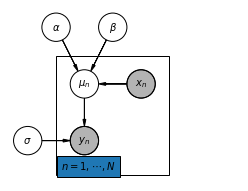

In [5]:
import daft

# Instantiate the PGM.
pgm = daft.PGM(shape=[4.0, 3.0], origin=[-0.3, -0.7])

# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 0, 0))

# Deterministic variable.
pgm.add_node(daft.Node("mu", r"$\mu_n$", 1, 1))

# Data.
pgm.add_node(daft.Node("x", r"$x_n$", 2, 1, observed=True))
pgm.add_node(daft.Node("y", r"$y_n$", 1, 0, observed=True))

# Add in the edges.
pgm.add_edge("alpha", "mu")
pgm.add_edge("beta", "mu")
pgm.add_edge("x", "mu")
pgm.add_edge("mu", "y")
pgm.add_edge("sigma", "y")

# And a plate.
pgm.add_plate(daft.Plate([0.5, -0.5, 2, 2], label=r"$n = 1, \cdots, N$",
    shift=-0.1))

# Render and save.
pgm.render()
pgm.figure.savefig("lm.pdf")

#### Setting up and fitting linear model

In [6]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

In [7]:
niter = 1000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    y_est = a*x + b     
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:22<00:00, 1835.99draws/s]
The acceptance probability does not match the target. It is 0.8794802254395183, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


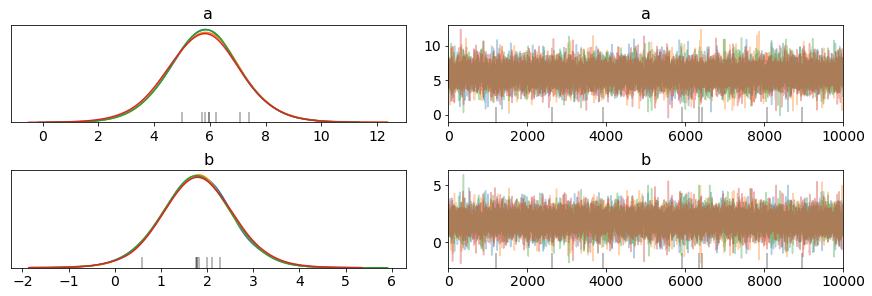

In [8]:
pm.traceplot(trace, varnames=['a', 'b'])
pass

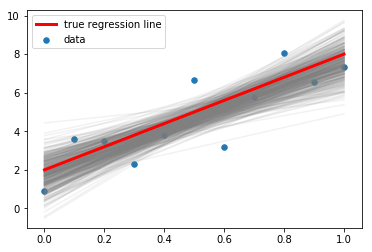

In [9]:
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(trace['a'][-100:], trace['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best')
pass

#### Posterior predictive checks

In [10]:
ppc = pm.sample_ppc(trace, samples=500, model=linreg, size=11)

/Users/cliburn/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 500/500 [00:00<00:00, 1278.38it/s]


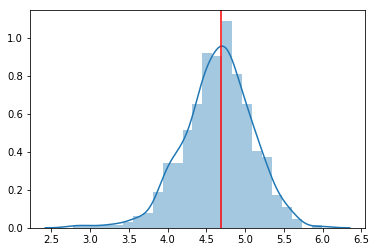

In [11]:
sns.distplot([np.mean(n) for n in ppc['y']], kde=True)
plt.axvline(np.mean(y), color='red')
pass

## Using the GLM module

In [12]:
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.0,0.914369
1,0.1,3.597345
2,0.2,3.482978
3,0.3,2.293705
4,0.4,3.821400


In [13]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', df)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1832.73draws/s]


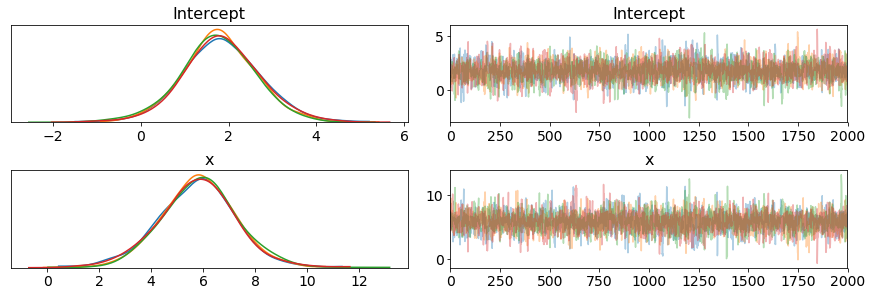

In [14]:
pm.traceplot(trace, varnames=['Intercept', 'x'])
pass

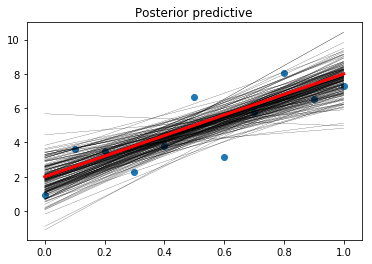

In [15]:
plt.scatter(x, y)
pm.plot_posterior_predictive_glm(trace, samples=200)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
pass

## Robust linear regression

If our data has outliers, we can perform a robust regression by modeling errors from a fatter tailed distribution than the normal distribution.

In [63]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)
y[5] *=10 # create outlier
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.0,0.914369
1,0.1,3.597345
2,0.2,3.482978
3,0.3,2.293705
4,0.4,3.821400


#### Effect of outlier on linear regression

In [18]:
niter = 1000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    y_est = pm.Deterministic('mu', a*x + b)
    y_obs = pm.Normal('y_obs', mu=y_est, sd=sigma, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1550.98draws/s]


In [34]:
with linreg:
    pp = pm.sample_posterior_predictive(trace, samples=100, vars=[a, b])

100%|██████████| 100/100 [00:00<00:00, 17949.69it/s]


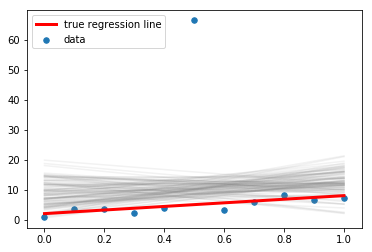

In [37]:
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(pp['a'], pp['b']):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='upper left')
pass

#### Use a T-distribution for the errors for a more robust fit

Note how we sample [a, b] as a vector β using the `shape` argument.

In [38]:
niter = 1000
with pm.Model() as robust_linreg:
    beta = pm.Normal('beta', 0, 10, shape=2)
    nu = pm.Exponential('nu', 1/len(x))
    sigma = pm.HalfCauchy('sigma', beta=1)

    y_est = beta[0] + beta[1]*x
    y_obs = pm.StudentT('y_obs', mu=y_est, sd=sigma, nu=nu, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, beta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1098.33draws/s]
The acceptance probability does not match the target. It is 0.6594644367900713, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [42]:
with robust_linreg:
    pp = pm.sample_posterior_predictive(trace, samples=100, vars=[beta])

100%|██████████| 100/100 [00:00<00:00, 19106.71it/s]


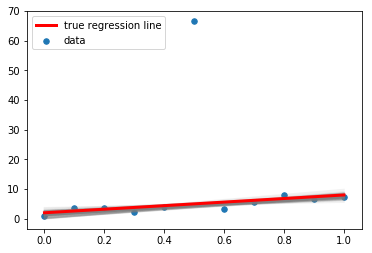

In [52]:
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(pp['beta'][:,1], pp['beta'][:,0]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='upper left')
pass

### Using the GLM module

In [64]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', df, 
                            family=pm.glm.families.StudentT())
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, x, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:07<00:00, 1388.73draws/s]


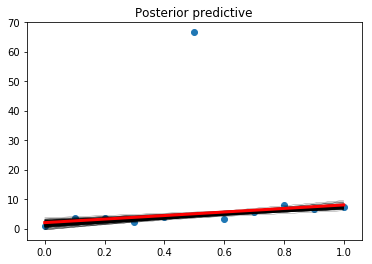

In [65]:
plt.scatter(x, y)
pm.plot_posterior_predictive_glm(trace, samples=200)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
pass

## Logistic regression

We will look at the effect of strongly correlated variabels using a data set from Kruschke's book.

In [66]:
df = pd.read_csv('data/HtWt.csv')
df.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [71]:
niter = 1000
with pm.Model() as model:
    pm.glm.GLM.from_formula('male ~ height + weight', df, 
                            family=pm.glm.families.Binomial()) 
    trace = pm.sample(niter, cores=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight, height, Intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:31<00:00, 81.90draws/s] 
The acceptance probability does not match the target. It is 0.8924373330407579, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8864107495327165, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940769483165639, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


#### Note that NUTS performs well despite the correlation between height and weight

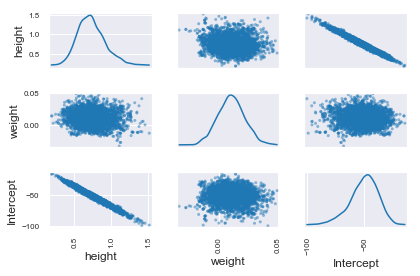

In [75]:
df_trace = pm.trace_to_dataframe(trace)
pd.plotting.scatter_matrix(df_trace.loc[-niter//2:, ['height', 'weight', 'Intercept']], diagonal='kde')
plt.tight_layout()
pass

### Logistic regression for classification

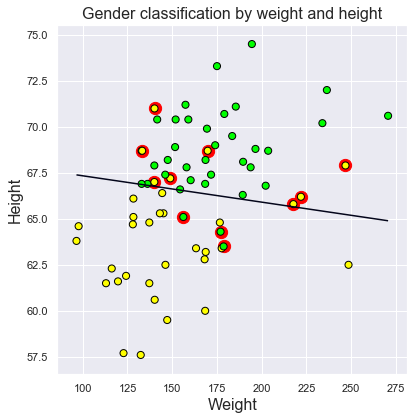

In [77]:
height, weight, intercept = df_trace[['height', 'weight', 'Intercept']].mean(0)

def predict(w, h, intercept=intercept, height=height, weight=weight):
    """Predict gender given weight (w) and height (h) values."""
    v = intercept + height*h + weight*w
    return np.exp(v)/(1+np.exp(v))

# calculate predictions on grid
xs = np.linspace(df.weight.min(), df.weight.max(), 100)
ys = np.linspace(df.height.min(), df.height.max(), 100)
X, Y = np.meshgrid(xs, ys)
Z = predict(X, Y)

plt.figure(figsize=(6,6))
# plot 0.5 contour line - classify as male if above this line
plt.contour(X, Y, Z, levels=[0.5])

# classify all subjects
colors = ['lime' if i else 'yellow' for i in df.male]
ps = predict(df.weight, df.height)
errs = ((ps < 0.5) & df.male) |((ps >= 0.5) & (1-df.male))
plt.scatter(df.weight[errs], df.height[errs], facecolors='red', s=150)
plt.scatter(df.weight, df.height, facecolors=colors, edgecolors='k', s=50, alpha=1);
plt.xlabel('Weight', fontsize=16)
plt.ylabel('Height', fontsize=16)
plt.title('Gender classification by weight and height', fontsize=16)
plt.tight_layout();

## Logistic model not using `glm`

Gelman's book has an example where the dose of a drug may be affected to the number of rat deaths in an experiment.

| Dose (log g/ml) | # Rats | # Deaths |
|-----------------|--------|----------|
| -0.896          | 5      | 0        |
| -0.296          | 5      | 1        |
| -0.053          | 5      | 3        |
| 0.727           | 5      | 5        |

We will model the number of deaths as a random sample from a binomial distribution, where $n$ is the number of rats and $p$ the probability of a rat dying. We are given $n = 5$, but we believe that $p$ may be related to the drug dose $x$. As $x$ increases the number of rats dying seems to increase, and since $p$ is a probability, we use the following model:

$$
y \sim \text{Bin}(n, p) \\
\text{logit}(p) = \alpha + \beta x \\
\alpha \sim \mathcal{N}(0, 5) \\
\beta \sim \mathcal{N}(0, 10)
$$

where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

#### Observed data

In [78]:
n = 5 * np.ones(4)
x = np.array([-0.896, -0.296, -0.053, 0.727])
y = np.array([0, 1, 3, 5])

In [80]:
def invlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Flat('beta')
    
    p = invlogit(alpha + beta*x)
    y_obs = pm.Binomial('y_obs', n=n, p=p, observed=y)
    
    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2678.59draws/s]


100%|██████████| 100/100 [00:00<00:00, 18076.56it/s]


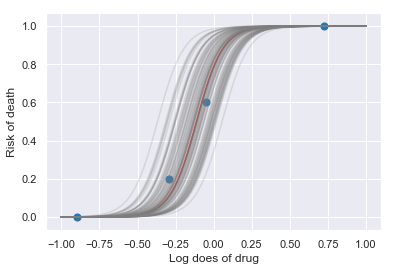

In [85]:
def logit(a, b, xp): 
    return np.exp(a + b*xp)/(1 + np.exp(a + b*xp))

with model:
    pp = pm.sample_posterior_predictive(trace, samples=100, vars=[alpha, beta])

xp = np.linspace(-1, 1, 100)
a = trace['alpha'].mean()
b = trace['beta'].mean()
plt.plot(xp, logit(a, b, xp), c='red')

for a_, b_ in zip(pp['alpha'], pp['beta']):
    plt.plot(xp, logit(a_, b, xp), c='gray', alpha=0.2)

plt.scatter(x, y/5, s=50);
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death')
pass

## Hierarchical model

This uses the Gelman radon data set and is based off this [IPython notebook](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/). Radon levels were measured in houses from all counties in several states. Here we want to know if the presence of a basement affects the level of radon, and if this is affected by which county the house is located in. 

![Radon](http://www.bestinspectionsllc.com/wp-content/uploads/2016/09/how-radon-enters-a-house.jpg)

The data set provided is just for the state of Minnesota, which has 85 counties with 2 to 116 measurements per county. We only need 3 columns for this example `county`, `log_radon`, `floor`, where `floor=0` indicates that there is a basement.

We will perform simple linear regression on log_radon as a function of county and floor.

In [86]:
radon = pd.read_csv('data/radon.csv')[['county', 'floor', 'log_radon']]
radon.head()

,county,floor,log_radon
0,AITKIN,1.0,0.832909
1,AITKIN,0.0,0.832909
2,AITKIN,0.0,1.098612
3,AITKIN,0.0,0.095310
4,ANOKA,0.0,1.163151


### Pooled model

In the pooled model, we ignore the county infomraiton.

$$
y \sim \mathcal{N}(a + bx, \sigma^2)
$$

where $y$ is the log radon level, and $x$ an indicator variable for whether there is a basement or not.

We make up some choices for the fairly uniformative priors as usual

$$
a \sim \mathcal{N}(\mu, \sigma_a^2) \\
b \sim \mathcal{N}(\mu, \sigma_b^2) \\
\sigma \sim \text{Gamma(10, 1)}
$$

However, since the radon level varies by geographical location, it might make sense to include county information in the model. One way to do this is to build a separate regression model for each county, but the sample sizes for some counties may be too small for precise estimates. A compromise between the pooled and separate county models is to use a hierarchical model for *patial pooling* - the practical efffect of this is to shrink per county estimates towards the group mean, especially for counties with few observations.

#### Hierarchical model

With a hierarchical model, there is an $a_c$ and a $b_c$ for each county $c$ just as in the individual county model, but they are no longer independent but assumed to come from a common group distribution

$$
a_c \sim \mathcal{N}(\mu_a, \sigma_a^2) \\
b_c \sim \mathcal{N}(\mu_b, \sigma_b^2)
$$

we further assume that the hyperparameters come from the following distributions

$$
\mu_a \sim \mathcal{N}(0, 10^2) \\
\sigma_a \sim \text{|Cauchy(1)|} \\ 
\mu_b \sim \mathcal{N}(0, 10^2) \\
\sigma_b \sim \text{|Cauchy(1)|} \\ 
$$

The variance for observations does not change, so the model for the radon level is

$$
y \sim \mathcal{N}(a_c + b_c x, \sigma^2)
$$

### Pooled model

In [89]:
niter = 1000
with pm.Model() as pl:
    # County hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.HalfCauchy('sigma_b', beta=1)
    
    # County slopes and intercepts
    a = pm.Normal('slope', mu=mu_a, sd=sigma_a)
    b = pm.Normal('intercept', mu=mu_b, sd=sigma_b)
    
    # Houseehold errors
    sigma = pm.Gamma("sigma", alpha=10, beta=1)
    
    # Model prediction of radon level
    mu = a + b * radon.floor.values
    
    # Data likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=radon.log_radon)

    pl_trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:10<00:00, 547.33draws/s] 
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.645357507542253, but should be close to 0.8. Try to increase the number of tuning steps.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7207731872428942, but should be close to 0.8. Try to increase the number of tuning steps.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6299390583115543, but should be close to 0.8. Try to increase the number of tuning steps.
There were 527 divergences after t

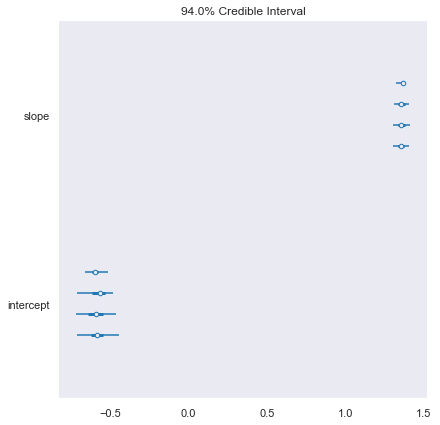

In [94]:
pm.forestplot(pl_trace, varnames=['slope', 'intercept'])
pass

### Hierarchical model

In [87]:
county = pd.Categorical(radon['county']).codes

niter = 1000
with pm.Model() as hm:
    # County hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.HalfCauchy('sigma_b', beta=1)
    
    # County slopes and intercepts
    a = pm.Normal('slope', mu=mu_a, sd=sigma_a, shape=len(set(county)))
    b = pm.Normal('intercept', mu=mu_b, sd=sigma_b, shape=len(set(county)))
    
    # Houseehold errors
    sigma = pm.Gamma("sigma", alpha=10, beta=1)
    
    # Model prediction of radon level
    mu = a[county] + b[county] * radon.floor.values
    
    # Data likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=radon.log_radon)

    hm_trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:17<00:00, 347.88draws/s]
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6622574623247153, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5654464499950719, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


#### Compare the length of the credible interval with the number of observations for each county.

In [114]:
cat = pd.Categorical(radon['county'])
pd.DataFrame(dict(
    code=range(len(cat.categories)),
    n=pd.value_counts(pd.Categorical(radon['county']), sort=False), 
)).sort_values('n')

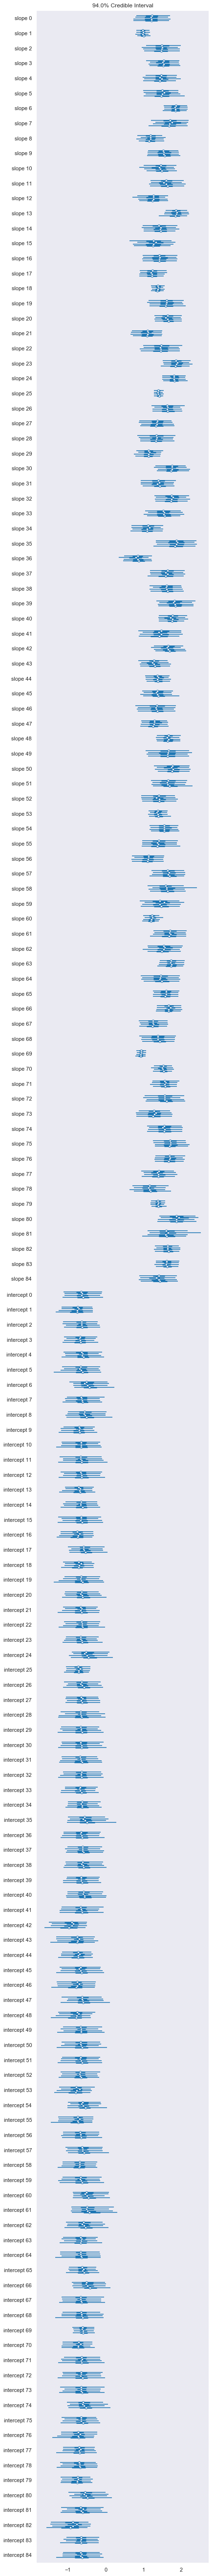

In [100]:
pm.forestplot(hm_trace, varnames=['slope', 'intercept'])
pass

### Comparing models

In [147]:
hm.name = 'hierarchical'
pl.name = 'pooled'
df_loo = pm.compare({pl: pl_trace, hm: hm_trace}, ic='LOO')
df_loo

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
hierarchical,2077.26,63.35,0,0.9,56.7,0,1
pooled,2178.84,3.21,101.58,0.1,49.8,22.55,0


In [146]:
df_waic = pm.compare({pl: pl_trace, hm: hm_trace}, ic='WAIC')
df_waic

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
hierarchical,2075.25,62.34,0,0.9,56.49,0,1
pooled,2178.84,3.21,103.59,0.1,49.8,22.4,0
